# Embedding visualization
Code inspired by [this repo](https://github.com/rmeertens/Simplest-Tensorflow-Tensorboard-MNIST-Embedding-Visualisation/blob/master/Minimal%20example%20embeddings.ipynb). Also see [this](https://github.com/rmeertens/Simplest-Tensorflow-Tensorboard-MNIST-Embedding-Visualisation/issues/1) issue related to tensorflow 2.0. As such we work in an environment with tensorflow 1.15.

In [2]:
%load_ext tensorboard
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os, sys
from tensorboard.plugins import projector


sys.path.append("..")
from src.utils.geo import *
from src.data.dataset import *
from src.model.network import get_model

tf.enable_eager_execution()

LOG_DIR = '../logs'
NAME_TO_VISUALISE_VARIABLE = "loc2vec_embedding"
TO_EMBED_COUNT = 500


path_for_sprites =  os.path.join(LOG_DIR,'loc2vec.png')
path_for_metadata =  os.path.join(LOG_DIR,'loc2vec.tsv')

In [3]:
print(tf.__version__)

1.15.0


## Get embeddings

In [4]:
pathstring = "../data/tiles/"
df = get_files_from_path(pathstring)
dataset = get_dataset(df)

model = get_model()
model.load_weights("../models/checkpoints/model")



for ix, (x, y) in enumerate(dataset):
    embeddings = model(x).numpy()
    if ix == 0:
        images = x.numpy()
        embeddings_var = embeddings
    else:
        images = np.concatenate((images, x.numpy()), axis=0)
        embeddings_var = np.concatenate((embeddings_var, embeddings))
    if embeddings_var.shape[0]>TO_EMBED_COUNT:
        break        
    

### Save embeddings

In [5]:
tf.disable_eager_execution()
embedding_var = tf.Variable(embeddings_var, name=NAME_TO_VISUALISE_VARIABLE)
summary_writer = tf.summary.FileWriter(LOG_DIR)

In [6]:
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

# Specify where you find the metadata
embedding.metadata_path = path_for_metadata #'metadata.tsv'

# Specify where you find the sprite (we will create this later)
embedding.sprite.image_path = path_for_sprites #'mnistdigits.png'
embedding.sprite.single_image_dim.extend([128,128])

# Say that you want to visualise the embeddings
projector.visualize_embeddings(summary_writer, config)

In [7]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"), 1)

'../logs/model.ckpt-1'

### Save metadata
We don't use the metadata, but tensorboard will complain if it is not there.

In [8]:
with open(path_for_metadata,'w') as f:
    f.write("Index\tLabel\n")
    for index,label in enumerate(np.ones(embedding_var.shape[0])):
        f.write("%d\t%d\n" % (index,label))

### Visualization helper function

In [9]:
def create_sprite_image(images):
    """Returns a sprite image consisting of images passed as argument. Images should be count x width x height x channels"""
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    
    
    spriteimage = np.ones((img_h * n_plots ,img_w * n_plots, 3))
    
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                spriteimage[i * img_h:(i + 1) * img_h,
                  j * img_w:(j + 1) * img_w] = this_img
    
    return spriteimage


### Save sprite images

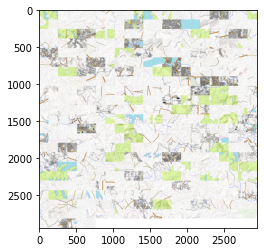

In [10]:
sprite_image = create_sprite_image(images)

plt.imsave(path_for_sprites,sprite_image)
plt.imshow(sprite_image,cmap='gray')

Run 
`tensorboard --logdir logs/`
in the terminal or `%tensorboard --logdir ../logs` in jupyter.